In [1]:
%env CUDA_VISIBLE_DEVICES=8

import sys
sys.path.append("../src/")

env: CUDA_VISIBLE_DEVICES=8


In [2]:
import torch

torch.backends.fp32_precision = "tf32"
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True


from transformers import AutoModelForCausalLM, AutoTokenizer

/nfs/scistore19/alistgrp/apanfero/micromamba/envs/llmb/lib/python3.10/site-packages/torch/cuda/__init__.py:799: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-3.2-1B",
    device_map="cuda",
    torch_dtype=torch.float32,
)

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")

In [4]:
from torch import nn

def find_linear_layers(module: nn.Module, name='') -> dict[str, nn.Module]:
    """
    Returns a dict of all nn.Linear submodules in a module with paths as keys
    """
    if type(module) == nn.Linear:
        return {name: module}
    res = {}
    for name1, child in module.named_children():
        res.update(find_linear_layers(
            child, name=name + '.' + name1 if name != '' else name1
        ))
    return res


def replace_submodule(module, submodule_path, new_submodule):
    """
    Replaces a submodule specified by a path with a new submodule
    """
    submodule_names = submodule_path.split(".")
    for submodule in submodule_names[:-1]:
        module = getattr(module, submodule)
    setattr(module, submodule_names[-1], new_submodule)

In [5]:
from tqdm.auto import tqdm, trange

from models.quantization.schemes import Quartet_II_Linear, TetraJetV2Linear, NvidiaLinear

linear_submodules = find_linear_layers(model.model)
for name, linear in tqdm(linear_submodules.items(), desc="Replacing nn.Linear submodules"):
    qlinear = NvidiaLinear(
        linear.in_features, linear.out_features,
        device=linear.weight.device, dtype=linear.weight.dtype,
        bias=linear.bias is not None,
        disable_forward_quant=True,
    )
    
    # qlinear = Quartet_II_Linear(
    #     linear.in_features, linear.out_features,
    #     device=linear.weight.device, dtype=linear.weight.dtype,
    #     bias=linear.bias is not None,
    #     disable_forward_quant=True,
    #     four_over_six=True, hadamard_dim=128,
    # )
    
    # qlinear = TetraJetV2Linear(
    #     linear.in_features, linear.out_features,
    #     device=linear.weight.device, dtype=linear.weight.dtype,
    #     bias=linear.bias is not None,
    #     disable_forward_quant=True,
    # )
    
    qlinear.weight = linear.weight
    replace_submodule(model.model, name, qlinear)

Replacing nn.Linear submodules:   0%|          | 0/112 [00:00<?, ?it/s]

In [6]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): NvidiaLinear(in_features=2048, out_features=2048, bias=False)
          (k_proj): NvidiaLinear(in_features=2048, out_features=512, bias=False)
          (v_proj): NvidiaLinear(in_features=2048, out_features=512, bias=False)
          (o_proj): NvidiaLinear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): NvidiaLinear(in_features=2048, out_features=8192, bias=False)
          (up_proj): NvidiaLinear(in_features=2048, out_features=8192, bias=False)
          (down_proj): NvidiaLinear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMS

In [7]:
for name, p in model.named_parameters():
    p.requires_grad_(True)

for p in model.parameters():
    p.grad = None

for module in model.modules():
    if isinstance(module, nn.Linear):
        module.disable_backward_quant = True

def get_loss(model):
    return -nn.functional.log_softmax(model(
        **tokenizer(
            """Lorem ipsum dolor sit amet, consectetur adipiscing elit. Aliquam fringilla neque eget efficitur bibendum. Proin vitae interdum dolor. Phasellus porttitor augue eu ullamcorper finibus. Donec molestie velit nec dolor gravida dignissim. Suspendisse laoreet erat quis dui pretium lacinia. Mauris interdum est eget tellus ullamcorper, vitae pellentesque lacus accumsan. Donec euismod quam nisl, ac euismod lorem rutrum a. Aenean eget porta nunc. Es""",
            return_tensors='pt',
        ).to(model.device),
        use_cache=False,
    ).logits, dim=-1)[0,-1, 325]

get_loss(model).backward()

/nfs/scistore19/alistgrp/apanfero/micromamba/envs/llmb/lib/python3.10/site-packages/torch/cuda/__init__.py:799: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [8]:
ref_grads = {}

for name, p in model.named_parameters():
    if p.requires_grad:
        if p.grad is None:
            raise Exception(f"Parameter {name} has no grad!")
        ref_grads[name] = p.grad.clone().detach()

In [9]:
for module in model.modules():
    if isinstance(module, nn.Linear):
        module.disable_backward_quant = False

grad_err = {k: {} for k in ref_grads}

for acc_steps in tqdm([1, 4, 16, 64, 256, 1024]):
    for p in model.parameters():
        p.grad = None
    
    for step in trange(acc_steps, leave=False):
        get_loss(model).backward()
    
    for name, p in model.named_parameters():
        if p.requires_grad:
            if p.grad is None:
                raise Exception(f"Parameter {name} has no grad!")
            p.grad /= acc_steps
            
            ref = ref_grads[name]
            grad = p.grad
            
            quad_err = (grad - ref).pow(2).mean() / ref.pow(2).mean()
            eff_bitwidth = (-torch.log2(quad_err) / 2).item()
            grad_err[name][acc_steps] = quad_err.item()


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/nfs/scistore19/alistgrp/apanfero/micromamba/envs/llmb/lib/python3.10/site-packages/torch/_dynamo/variables/functions.py:1391: UserWarning: Dynamo does not know how to trace the builtin `<unknown module>.Tensor.reshape.` This function is either a Python builtin (e.g. _warnings.warn) or a third-party C/C++ Python extension (perhaps created with pybind).
If it is a Python builtin, please file an issue on GitHub so the PyTorch team can add support for it and see the next case for a workaround.
If it is a third-party C/C++ Python extension, please either wrap it into a PyTorch-understood custom operator (see https://pytorch.org/tutorials/advanced/custom_ops_landing_page.html for more details) or, if it is traceable, use `torch.compiler.allow_in_graph`.
  torch._dynamo.utils.warn_once(explanation + "\n" + "\n".join(hints))
W0127 14:52:34.771000 2888788 site-packages/torch/_dynamo/convert_frame.py:987] [7/8] torch._dynamo hit config.recompile_limit (8)
W0127 14:52:34.771000 2888788 site-pack

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

In [10]:
import json

with open("../data/46_concentration.json", "w") as f:
    json.dump(grad_err, f)

Text(0, 0.5, '$\\|\\frac{1}{N}\\sum\\widehat{G} - G\\|_2^2$')

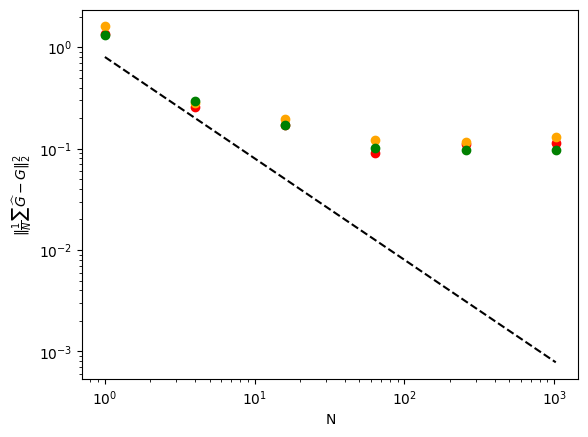

In [11]:
import numpy as np
import matplotlib.pyplot as plt

key_color = {
    "model.layers.0.self_attn.q_proj.weight": "red",
    "model.layers.0.self_attn.k_proj.weight": "orange",
    "model.layers.0.self_attn.v_proj.weight": "green",
}

for key, color in key_color.items():
    data = grad_err[key]
    
    plt.scatter(data.keys(), data.values(), label=key, color=color)


x = np.logspace(0, 5, num=50, base=4)
y = 0.8 / x

plt.plot(x, y, color="black", linestyle="--", label="1/N")

    
plt.xscale('log')
plt.yscale('log')

plt.xlabel("N")

plt.ylabel(r"$\|\frac{1}{N}\sum\widehat{G} - G\|_2^2$")

In [12]:
y

array([8.00000000e-01, 6.94472885e-01, 6.02865736e-01, 5.23342383e-01,
       4.54308869e-01, 3.94381489e-01, 3.42359063e-01, 2.97198858e-01,
       2.57995685e-01, 2.23963760e-01, 1.94420948e-01, 1.68775096e-01,
       1.46512160e-01, 1.27185903e-01, 1.10408951e-01, 9.58450288e-02,
       8.32022171e-02, 7.22271047e-02, 6.26997073e-02, 5.44290583e-02,
       4.72493814e-02, 4.10167678e-02, 3.56062914e-02, 3.09095049e-02,
       2.68322663e-02, 2.32928517e-02, 2.02203174e-02, 1.75530777e-02,
       1.52376707e-02, 1.32276864e-02, 1.14828369e-02, 9.96814861e-03,
       8.65326116e-03, 7.51181906e-03, 6.52094332e-03, 5.66077290e-03,
       4.91406661e-03, 4.26585752e-03, 3.70315298e-03, 3.21467417e-03,
       2.79063006e-03, 2.42252113e-03, 2.10296905e-03, 1.82556873e-03,
       1.58475998e-03, 1.37571604e-03, 1.19424686e-03, 1.03671508e-03,
       8.99963142e-04, 7.81250000e-04])